In [ ]:
import torch # We no longer import as tch
import torch.nn as nn
import numpy as np
import torchvision # Contains data sets and functions for image processing
import torchvision.transforms as transforms # Contains MNIST, other image datasets, and image processing functions
import matplotlib.pyplot as plt
from time import time as tm
import torch.nn.functional as F 
from copy import deepcopy
import seaborn as sns

# Import TorchSeq2PC 
!git clone https://github.com/RobertRosenbaum/Torch2PC.git
from Torch2PC import TorchSeq2PC as T2PC

SaveFigures=False

if SaveFigures:
  from google.colab import drive
  drive.mount("/content/gdrive/")
  

def ToOneHot(labels, num_classes):
    y = torch.eye(num_classes) 
    return y[labels] 

torch.manual_seed(0)


# # This patches an error that sometimes arises in
# # downloading MNIST
# from six.moves import urllib
# opener = urllib.request.build_opener()
# opener.addheaders = [('User-agent', 'Mozilla/5.0')]
# urllib.request.install_opener(opener)

# # This can also help errors that arise sometimes
# # when downloading MNIST
!wget -nc www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

# Load training and testing data from MNIST dataset
# These lines return data structures that contain
# the training and testing data 
from torchvision.datasets import MNIST

train_dataset = MNIST('./', 
      train=True, 
      transform=transforms.ToTensor(),  
      download=True)

test_dataset = MNIST('./', 
      train=False, 
      transform=transforms.ToTensor(),  
      download=True)


#train_dataset.data=train_dataset.data/255.0
#test_dataset.data=test_dataset.data/255.0

# Print the size of the two data sets
m = len(train_dataset)
mtest = len(test_dataset)
print("Number of data points in training set = ",m)
print("Number of data points in test set=",mtest)

# train_dataset.data contains all the MNIST images (X) 
# train_dataset.targets contains all the labels (Y)
print("Size of training inputs (X)=",train_dataset.data.size())
print("Size of training labels (Y)=",train_dataset.targets.size())


Cloning into 'Torch2PC'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 47 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (47/47), done.
Running TorchSeq2PC.py
--2021-06-17 17:11:14--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-06-17 17:11:14--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [     <=>            ]  33.20M  34.1MB/s    in 1.0s    

2021-06-17 17:11:15 (34.1 MB/s) - ‘MNIST.tar.gz’ saved 

In [ ]:
batch_size = 300      # Batch size to use with training data
test_batch_size = 300 # Batch size to use for test data

# Data loader. These make it easy to iterate through batches of data.
# Shuffle=True means that the data will be randomly shuffled on every epoch
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=test_batch_size,
                                          shuffle=True)


steps_per_epoch = len(train_loader) # = mini batch size = m'
print("steps per epoch (mini batch size)=",steps_per_epoch)


steps per epoch (mini batch size)= 200


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = ',device)

model=nn.Sequential(
    
    nn.Sequential(nn.Conv2d(1,10,3),
    nn.ReLU(),
    nn.MaxPool2d(2)
    ),

    nn.Sequential(
    nn.Conv2d(10,5,3),
    nn.ReLU(),
    nn.Flatten()
    ),

 nn.Sequential(
    nn.Linear(5*11*11,50),
    nn.ReLU()
    ),

 nn.Sequential(
    nn.Linear(50,30),
    nn.ReLU()
    ),


nn.Sequential(
   nn.Linear(30,10)
 )

).to(device)

LossFun = nn.MSELoss()

# Compute one output and one loss to make sure
# things are working
with torch.no_grad():
  TrainingIterator=iter(train_loader)
  X,Y=next(TrainingIterator)  
  X=X.to(device)
  Y=ToOneHot(Y,10).to(device)
  Yhat=model(X).to(device)
  print('output shape = ',Yhat.shape)
  print('loss on initial model = ',LossFun(Yhat,Y).item())

NumParams=sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters in model =',NumParams)


LearningRate=.002
num_epochs=2
ComputeTrainingMetrics=False
WhichOptimizer=torch.optim.Adam
PrintEvery=50
total_num_steps  = num_epochs*steps_per_epoch

device =  cuda
output shape =  torch.Size([300, 10])
loss on initial model =  0.10179933905601501
Number of trainable parameters in model = 32695


k = 0 i = 0 L = 0.09918276220560074
k = 0 i = 50 L = 0.041109032928943634
k = 0 i = 100 L = 0.024540701881051064
k = 0 i = 150 L = 0.017343096435070038
k = 1 i = 0 L = 0.011258048936724663
k = 1 i = 50 L = 0.010848945938050747
k = 1 i = 100 L = 0.007973755709826946
k = 1 i = 150 L = 0.006905510555952787
Training time =  30.85972785949707 sec


(0.0, 0.05500000000000001)

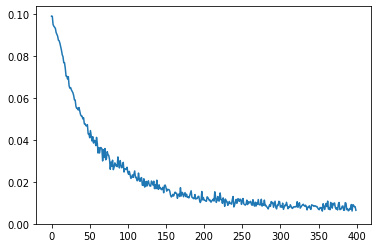

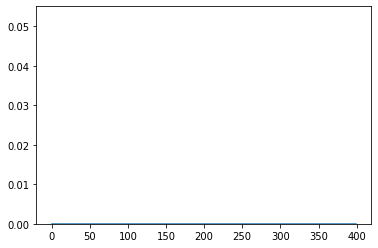

In [ ]:
torch.manual_seed(0)

modelPC=deepcopy(model)


optimizerPC = WhichOptimizer(modelPC.parameters(), lr=LearningRate)


jj=0
LossesToPlotPC=np.zeros(total_num_steps)
TestLossesToPlotPC=np.zeros(total_num_steps)
AccuraciesToPlotPC=np.zeros(total_num_steps)
TestAccuraciesToPlotPC=np.zeros(total_num_steps)

eta=.1
n=20

j=0     # Counter to keep track of iterations
t1=tm() # Start the timer

for k in range(num_epochs):

  # Re-initializes the training iterator (shuffles data for one epoch)
  TrainingIterator=iter(train_loader)
  
  for i in range(steps_per_epoch): # For each batch

    # Get one batch of training data, reshape it
    # and send it to the current device        
    X,Y=next(TrainingIterator)  
    X=X.to(device)
    Y=ToOneHot(Y,10).to(device)

    

    #vhat,Loss,dLdy=FwdPassPlus(modelPC,LossFun,X,Y)
    #_,epsilon=StrictPCPredErrs(modelPC,vhat,LossFun,Y,eta,n)
    #SetPCGrads(modelPC,epsilon,X,vhat)
    _,Loss,_,_,_=T2PC.PCInfer(modelPC,LossFun,X,Y,"Strict",eta,n)

    # Update parameters
    optimizerPC.step() 


    # Zero-out gradients     
    modelPC.zero_grad()
    optimizerPC.zero_grad()

    # Print loss, store loss, compute test loss
    with torch.no_grad():
      if(i%PrintEvery==0):
        print('k =',k,'i =',i,'L =',Loss.item())
      LossesToPlotPC[jj]=Loss.item() 
      if ComputeTrainingMetrics:    
        Yhat=modelPC(X) 
        AccuraciesToPlotPC[jj]=(torch.sum(torch.argmax(Y,axis=1)==torch.argmax(Yhat,axis=1))/test_batch_size).item()    
        modelPC.eval()
        TestingIterator=iter(test_loader)     
        Xtest,Ytest=next(TestingIterator)
        Xtest=Xtest.to(device)
        Ytest=ToOneHot(Ytest,10).to(device)
        YhatTest=modelPC(Xtest)
        TestLossesToPlotPC[jj]=LossFun(YhatTest,Ytest).item()                   
        TestAccuraciesToPlotPC[jj]=(torch.sum(torch.argmax(Ytest,axis=1)==torch.argmax(YhatTest,axis=1))/test_batch_size).item()
        modelPC.train()
      jj+=1

tTrainPC=tm()-t1
print('Training time = ',tTrainPC,'sec')

plt.figure()
plt.plot(LossesToPlotPC)
plt.ylim(bottom=0)  

plt.figure()
plt.plot(TestAccuraciesToPlotPC)
plt.ylim(bottom=0)  

k = 0 i = 0 L = 0.09918276220560074
k = 0 i = 50 L = 0.03899229317903519
k = 0 i = 100 L = 0.0198687631636858
k = 0 i = 150 L = 0.015402212738990784
k = 1 i = 0 L = 0.010326097719371319
k = 1 i = 50 L = 0.010642196983098984
k = 1 i = 100 L = 0.007452049758285284
k = 1 i = 150 L = 0.006222846917808056
Training time =  27.35818576812744 sec


(0.0, 0.05500000000000001)

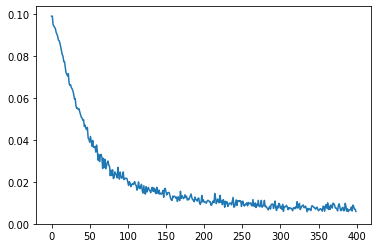

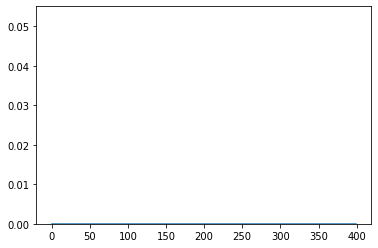

In [ ]:
torch.manual_seed(0)

modelPC=deepcopy(model)


optimizerPC = WhichOptimizer(modelPC.parameters(), lr=LearningRate)


jj=0
LossesToPlotPC=np.zeros(total_num_steps)
TestLossesToPlotPC=np.zeros(total_num_steps)
AccuraciesToPlotPC=np.zeros(total_num_steps)
TestAccuraciesToPlotPC=np.zeros(total_num_steps)

eta=.1
n=20

j=0     # Counter to keep track of iterations
t1=tm() # Start the timer

for k in range(num_epochs):

  # Re-initializes the training iterator (shuffles data for one epoch)
  TrainingIterator=iter(train_loader)
  
  for i in range(steps_per_epoch): # For each batch

    # Get one batch of training data, reshape it
    # and send it to the current device        
    X,Y=next(TrainingIterator)  
    X=X.to(device)
    Y=ToOneHot(Y,10).to(device)

    

    #vhat,Loss,dLdy=FwdPassPlus(modelPC,LossFun,X,Y)
    #_,epsilon=StrictPCPredErrs(modelPC,vhat,LossFun,Y,eta,n)
    #SetPCGrads(modelPC,epsilon,X,vhat)
    _,Loss,_,_,_=T2PC.PCInfer(modelPC,LossFun,X,Y,"FixedPred",eta,n)

    # Update parameters
    optimizerPC.step() 


    # Zero-out gradients     
    modelPC.zero_grad()
    optimizerPC.zero_grad()

    # Print loss, store loss, compute test loss
    with torch.no_grad():
      if(i%PrintEvery==0):
        print('k =',k,'i =',i,'L =',Loss.item())
      LossesToPlotPC[jj]=Loss.item() 
      if ComputeTrainingMetrics:    
        Yhat=modelPC(X) 
        AccuraciesToPlotPC[jj]=(torch.sum(torch.argmax(Y,axis=1)==torch.argmax(Yhat,axis=1))/test_batch_size).item()    
        modelPC.eval()
        TestingIterator=iter(test_loader)     
        Xtest,Ytest=next(TestingIterator)
        Xtest=Xtest.to(device)
        Ytest=ToOneHot(Ytest,10).to(device)
        YhatTest=modelPC(Xtest)
        TestLossesToPlotPC[jj]=LossFun(YhatTest,Ytest).item()                   
        TestAccuraciesToPlotPC[jj]=(torch.sum(torch.argmax(Ytest,axis=1)==torch.argmax(YhatTest,axis=1))/test_batch_size).item()
        modelPC.train()
      jj+=1

tTrainModPC=tm()-t1
print('Training time = ',tTrainModPC,'sec')

plt.figure()
plt.plot(LossesToPlotPC)
plt.ylim(bottom=0)  

plt.figure()
plt.plot(TestAccuraciesToPlotPC)
plt.ylim(bottom=0)  

k = 0 i = 0 L = 0.09918276220560074
k = 0 i = 50 L = 0.0383194237947464
k = 0 i = 100 L = 0.01949671469628811
k = 0 i = 150 L = 0.015400250442326069
k = 1 i = 0 L = 0.010208833031356335
k = 1 i = 50 L = 0.010423864237964153
k = 1 i = 100 L = 0.007705888710916042
k = 1 i = 150 L = 0.006233015563338995
Training time =  12.994442462921143 sec


(0.0, 0.05500000000000001)

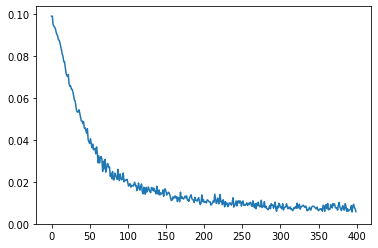

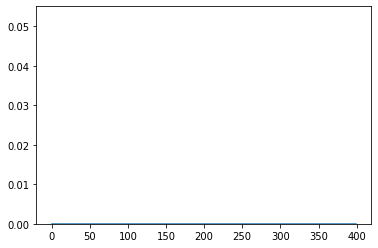

In [ ]:
torch.manual_seed(0)

modelPC=deepcopy(model)


optimizerPC = WhichOptimizer(modelPC.parameters(), lr=LearningRate)


jj=0
LossesToPlotPC=np.zeros(total_num_steps)
TestLossesToPlotPC=np.zeros(total_num_steps)
AccuraciesToPlotPC=np.zeros(total_num_steps)
TestAccuraciesToPlotPC=np.zeros(total_num_steps)

eta=1
n=len(model)

j=0     # Counter to keep track of iterations
t1=tm() # Start the timer

for k in range(num_epochs):

  # Re-initializes the training iterator (shuffles data for one epoch)
  TrainingIterator=iter(train_loader)
  
  for i in range(steps_per_epoch): # For each batch

    # Get one batch of training data, reshape it
    # and send it to the current device        
    X,Y=next(TrainingIterator)  
    X=X.to(device)
    Y=ToOneHot(Y,10).to(device)

    

    #vhat,Loss,dLdy=FwdPassPlus(modelPC,LossFun,X,Y)
    #_,epsilon=StrictPCPredErrs(modelPC,vhat,LossFun,Y,eta,n)
    #SetPCGrads(modelPC,epsilon,X,vhat)
    _,Loss,_,_,_=T2PC.PCInfer(modelPC,LossFun,X,Y,"FixedPred",eta,n)

    # Update parameters
    optimizerPC.step() 


    # Zero-out gradients     
    modelPC.zero_grad()
    optimizerPC.zero_grad()

    # Print loss, store loss, compute test loss
    with torch.no_grad():
      if(i%PrintEvery==0):
        print('k =',k,'i =',i,'L =',Loss.item())
      LossesToPlotPC[jj]=Loss.item() 
      if ComputeTrainingMetrics:    
        Yhat=modelPC(X) 
        AccuraciesToPlotPC[jj]=(torch.sum(torch.argmax(Y,axis=1)==torch.argmax(Yhat,axis=1))/test_batch_size).item()    
        modelPC.eval()
        TestingIterator=iter(test_loader)     
        Xtest,Ytest=next(TestingIterator)
        Xtest=Xtest.to(device)
        Ytest=ToOneHot(Ytest,10).to(device)
        YhatTest=modelPC(Xtest)
        TestLossesToPlotPC[jj]=LossFun(YhatTest,Ytest).item()                   
        TestAccuraciesToPlotPC[jj]=(torch.sum(torch.argmax(Ytest,axis=1)==torch.argmax(YhatTest,axis=1))/test_batch_size).item()
        modelPC.train()
      jj+=1

tTrainModPCEta1=tm()-t1
print('Training time = ',tTrainModPCEta1,'sec')

plt.figure()
plt.plot(LossesToPlotPC)
plt.ylim(bottom=0)  

plt.figure()
plt.plot(TestAccuraciesToPlotPC)
plt.ylim(bottom=0)  

k = 0 i = 0 L = 0.09918276220560074
k = 0 i = 50 L = 0.03791773319244385
k = 0 i = 100 L = 0.019594945013523102
k = 0 i = 150 L = 0.015203193761408329
k = 1 i = 0 L = 0.01029240246862173
k = 1 i = 50 L = 0.010502423159778118
k = 1 i = 100 L = 0.007618947885930538
k = 1 i = 150 L = 0.00624063378199935
Training time =  7.541069269180298 sec


(0.0, 0.05500000000000001)

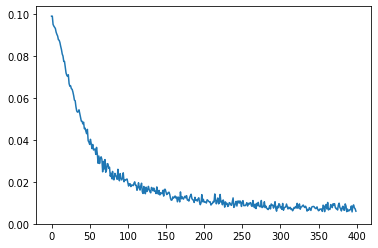

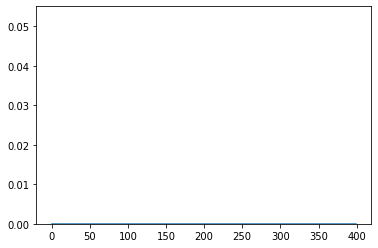

In [ ]:
torch.manual_seed(0)

modelBP=deepcopy(model)

optimizerBP = WhichOptimizer(modelBP.parameters(), lr=LearningRate)

total_num_steps  = num_epochs*steps_per_epoch


jj=0
LossesToPlotBP=np.zeros(total_num_steps)
TestLossesToPlotBP=np.zeros(total_num_steps)
AccuraciesToPlotBP=np.zeros(total_num_steps)
TestAccuraciesToPlotBP=np.zeros(total_num_steps)


DepthPlusOne=len(modelBP)+1 # Number of layers, counting the input as layer 0  

j=0     # Counter to keep track of iterations
t1=tm() # Start the timer
for k in range(num_epochs):

  # Re-initializes the training iterator (shuffles data for one epoch)
  TrainingIterator=iter(train_loader)

  for i in range(steps_per_epoch): # For each batch

    # Get one batch of training data, reshape it
    # and send it to the current device        
    X,Y=next(TrainingIterator)  
    X=X.to(device)
    Y=ToOneHot(Y,10).to(device)


    # _,Loss,_,_,_=T2PC.PCInfer(modelBP,LossFun,X,Y,"Exact")
    # optimizerBP.step()

    Yhat = modelBP(X)     # Forward pass
    Loss = LossFun(Yhat, Y)        
    Loss.backward()       # Compute gradients
    optimizerBP.step()      # Update parameters


    # Zero-out gradients 
    modelBP.zero_grad() 
    optimizerBP.zero_grad() 

    with torch.no_grad():
      if(i%PrintEvery==0):
        print('k =',k,'i =',i,'L =',Loss.item())
      LossesToPlotBP[jj]=Loss.item()      
      if ComputeTrainingMetrics:   
        AccuraciesToPlotBP[jj]=(torch.sum(torch.argmax(Y,axis=1)==torch.argmax(Yhat,axis=1))/test_batch_size).item()
        modelBP.eval() 
        TestingIterator=iter(test_loader)
        Xtest,Ytest=next(TestingIterator)
        Xtest=Xtest.to(device)
        Ytest=ToOneHot(Ytest,10).to(device)
        YhatTest=modelBP(Xtest)        
        TestLossesToPlotBP[jj]=LossFun(YhatTest,Ytest).item()             
        TestAccuraciesToPlotBP[jj]=(torch.sum(torch.argmax(Ytest,axis=1)==torch.argmax(YhatTest,axis=1))/test_batch_size).item()
        modelBP.train()
      jj+=1

tTrainBP=tm()-t1
print('Training time = ',tTrainBP,'sec')

plt.figure()
plt.plot(LossesToPlotBP)
plt.ylim(bottom=0)

plt.figure()
plt.plot(TestAccuraciesToPlotBP)
plt.ylim(bottom=0)

In [ ]:
print('Strict PC: ',tTrainPC)
print('Mod PC: ',tTrainModPC)
print('Mod PC eta=1: ',tTrainModPCEta1)
print('BP: ',tTrainBP)

Strict PC:  30.85972785949707
Mod PC:  27.35818576812744
Mod PC eta=1:  12.994442462921143
BP:  7.541069269180298
